# KBO 승패예측

# import

In [ ]:
import requests
import json
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# KBO data Crawling

In [ ]:
start = datetime.datetime.strptime("20170101", "%Y%m%d") # ★여기만 수정★ START DATE
end = datetime.datetime.strptime("20210930", "%Y%m%d") # ★여기만 수정★ END DATE
date_generated = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
game_list=[]
data = {'MIME Type': 'application/x-www-form-urlencoded; charset=UTF-8', 
        'leId': 1,
        'srId': 0,
        'date': '20201030'
        } 
for date in date_generated:
    data['date']=date.strftime("%Y%m%d")
    
    res = requests.post('https://www.koreabaseball.com/ws/Main.asmx/GetKboGameList', data=data)
    game = res.json()['game']
    game_num = len(game)
    for i in range(0,game_num):
        if game[i]['CANCEL_SC_ID'] == "0":
            game_list.append(game[i]['G_ID'])

In [ ]:
result = pd.DataFrame()
for g_id in game_list:
    
    data = {'MIME Type': 'application/x-www-form-urlencoded; charset=UTF-8', 
            'leId': 1,
            'srId': 0,
            'seasonId': 2020,
            'gameId': '20201030KTOB0'
           } 
    data['seasonId'] = g_id[:4]
    data['gameId'] = g_id
    url_base_sc = 'https://www.koreabaseball.com/ws/Schedule.asmx/GetScoreBoardScroll'
    url_base_bs = 'https://www.koreabaseball.com/ws/Schedule.asmx/GetBoxScoreScroll'
    res_sc = requests.post(url_base_sc, data = data)
    res_bs = requests.post(url_base_bs, data = data)

    try:
        table1 = res_sc.json()['table1'].replace('\r\n','')
        table3 = res_sc.json()['table3'].replace('\r\n','')

        hitter = res_bs.json()['arrHitter']
        hitter_away = hitter[0]['table3'].replace('\r\n','')
        hitter_home = hitter[1]['table3'].replace('\r\n','')

        pitcher = res_bs.json()['arrPitcher']
        pitcher_away = pitcher[0]['table'].replace('\r\n','')
        pitcher_home = pitcher[1]['table'].replace('\r\n','')
    except:
        continue
    
    dict1 = json.loads(table1)
    dict3 = json.loads(table3)
    dict_h1 = json.loads(hitter_away)
    dict_h2 = json.loads(hitter_home)
    dict_p1 = json.loads(pitcher_away)
    dict_p2 = json.loads(pitcher_home)

    date = res_sc.json()['G_DT']
    season = res_sc.json()['SEASON_ID']
    away_name = res_sc.json()['AWAY_NM']
    home_name = res_sc.json()['HOME_NM']

    away_score1 = []
    home_score1 = []
    away_score1.append(date) #경기 일자
    away_score1.append(season) #시즌
    away_score1.append(away_name) #원정팀 이름
    away_score1.append('Away')
    a = dict1['rows'][0]['row'][1]['Text'].split('>')[3]
    away_score1.append(a) #원정팀 현재 기록
    b = dict1['rows'][0]['row'][0]['Text']
    away_score1.append(b) #원정팀 해당경기 승/패
    
    home_score1.append(date)
    home_score1.append(season)
    home_score1.append(home_name) #홈팀 이름
    home_score1.append('Home')
    a = dict1['rows'][1]['row'][1]['Text'].split('>')[3]
    home_score1.append(a) #홈팀 현재 기록
    b = dict1['rows'][1]['row'][0]['Text']
    home_score1.append(b) #홈팀 해당경기 승/패
    
    away_score3 = []
    home_score3 = []
    for i in range(0,4): #R, H, E, B
        a = dict3['rows'][0]['row'][i]['Text']
        away_score3.append(a) 
        b = dict3['rows'][1]['row'][i]['Text']
        home_score3.append(b)
    
    away_score_h = []
    home_score_h = []
    for i in range(0,5): #타수, 안타, 타점, 득점, 타율
        a = dict_h1['tfoot'][0]['row'][i]['Text']
        away_score_h.append(a) 
        b = dict_h2['tfoot'][0]['row'][i]['Text']
        home_score_h.append(b)
    
    away_score_p = []
    home_score_p = []
    for i in range(1,12): #타수, 안타, 타점, 득점, 타율
        a = dict_p1['tfoot'][0]['row'][i]['Text']
        away_score_p.append(a) 
        b = dict_p2['tfoot'][0]['row'][i]['Text']
        home_score_p.append(b)
        
    score_board1 = pd.DataFrame([away_score1,home_score1],columns = ['Date','Season','Team','H&A','Result','Record'])
    score_board3 = pd.DataFrame([away_score3,home_score3],columns = ['R','H','E','B'])
    score_board_h = pd.DataFrame([away_score_h,home_score_h],columns = ['AB','HIT','RBI','RC','AVG'])
    score_board_p = pd.DataFrame([away_score_p,home_score_p],columns = ['IN','HITTER','PIT','타수p','피안타p','홈런p','4사구p','삼진p','실점p','자책p','평균자책점p'])
    score_board = pd.concat([score_board1,score_board3,score_board_h,score_board_p],axis=1) #두 테이블에서 가져온 정보 합치기
    result = result.append(score_board,ignore_index = True)
    print(g_id,"completion")
print("Finish")

# 데이터 전처리
#### 자료구조: dataframe
#### h: hitter
#### p: pitcher

In [ ]:
is_LG = result['Team']=='LG'
LG = result[is_LG].copy()

In [ ]:
LG.loc[LG['H&A']=='Home','H&A']=1
LG.loc[LG['H&A']=='Away','H&A']=0
LG.loc[LG['Record']=='승','Record']=1
LG.loc[LG['Record']=='패','Record']=0
LG.loc[LG['Record']=='무','Record']=2

In [ ]:
LG_sample=LG.loc[:,['H&A','Record','R','H','E','B','타수h','안타h','타점h','득점h','타율h','타자p','투구수p','타수p','피안타p','홈런p','4사구p','삼진p','실점p','자책p','평균자책점p']]
display(LG_sample)

,H&A,Record,R,H,E,B,타수h,안타h,타점h,득점h,...,타자p,투구수p,타수p,피안타p,홈런p,4사구p,삼진p,실점p,자책p,평균자책점p
8,0,1,2,4,1,3,31,4,1,2,...,34,122,30,5,0,4,6,1,1,1.00
14,0,1,8,11,0,2,36,11,8,8,...,40,147,37,12,0,3,9,3,3,3.00
28,0,1,9,10,1,5,36,10,7,9,...,33,136,28,3,0,4,6,2,1,1.00
31,1,1,11,16,1,3,41,16,11,11,...,37,133,35,7,0,2,12,0,0,0.00
41,1,1,4,8,0,3,29,8,4,4,...,31,105,31,4,0,0,7,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,1,0,4,10,1,2,35,10,3,4,...,42,139,39,13,3,2,6,7,7,7.00
6903,1,1,11,17,2,1,41,17,10,11,...,37,148,33,6,0,4,8,3,1,1.00
6918,0,2,0,5,0,2,28,5,0,0,...,30,125,27,4,0,3,3,0,0,0.00
6928,0,1,4,7,0,1,34,7,4,4,...,34,123,28,3,0,5,6,0,0,0.00


In [ ]:
LG_sample.to_csv('LG전처리data.txt')

# 여기까지 데이터 크롤링->저장
# 다음부터 저장한 데이터 사용

In [ ]:
LG_sample=pd.read_table('./LG전처리data.txt',sep=',')
LG_sample=LG_sample.loc[:,['H&A','Record','R','H','E','B','타수h','안타h','타점h','득점h','타율h','타자p','투구수p','타수p','피안타p','홈런p','4사구p','삼진p','실점p','자책p','평균자책점p']].copy()
display(LG_sample)

,H&A,Record,R,H,E,B,타수h,안타h,타점h,득점h,...,타자p,투구수p,타수p,피안타p,홈런p,4사구p,삼진p,실점p,자책p,평균자책점p
0,0,1,2,4,1,3,31,4,1,2,...,34,122,30,5,0,4,6,1,1,1.0
1,0,1,8,11,0,2,36,11,8,8,...,40,147,37,12,0,3,9,3,3,3.0
2,0,1,9,10,1,5,36,10,7,9,...,33,136,28,3,0,4,6,2,1,1.0
3,1,1,11,16,1,3,41,16,11,11,...,37,133,35,7,0,2,12,0,0,0.0
4,1,1,4,8,0,3,29,8,4,4,...,31,105,31,4,0,0,7,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,1,0,4,10,1,2,35,10,3,4,...,42,139,39,13,3,2,6,7,7,7.0
687,1,1,11,17,2,1,41,17,10,11,...,37,148,33,6,0,4,8,3,1,1.0
688,0,2,0,5,0,2,28,5,0,0,...,30,125,27,4,0,3,3,0,0,0.0
689,0,1,4,7,0,1,34,7,4,4,...,34,123,28,3,0,5,6,0,0,0.0


# 데이터 상관관계 분석

In [ ]:
LG_sample.corr(method='pearson')

,H&A,Record,R,H,E,B,타수h,안타h,타점h,득점h,...,타자p,투구수p,타수p,피안타p,홈런p,4사구p,삼진p,실점p,자책p,평균자책점p
H&A,1.000000,0.067118,-0.105556,-0.116882,-0.005167,-0.116657,-0.268930,-0.116882,-0.106448,-0.105556,...,0.057750,0.054997,0.120190,-0.073049,-0.150557,-0.092476,0.054788,-0.131090,-0.124232,-0.170066
Record,0.067118,1.000000,0.478126,0.362176,-0.152341,0.175871,0.199752,0.362176,0.472614,0.478126,...,-0.189117,-0.105243,-0.090079,-0.381250,-0.280264,-0.137649,0.189651,-0.533317,-0.500550,-0.530029
R,-0.105556,0.478126,1.000000,0.784504,0.024115,0.376656,0.600033,0.784504,0.989774,1.000000,...,0.127739,0.118882,0.176820,0.072330,0.081669,0.018012,0.145075,0.047155,0.056554,0.030834
H,-0.116882,0.362176,0.784504,1.000000,0.017719,0.163794,0.808615,1.000000,0.780646,0.784504,...,0.197837,0.175248,0.228055,0.111579,0.108234,0.060925,0.114766,0.084609,0.101218,0.074416
E,-0.005167,-0.152341,0.024115,0.017719,1.000000,-0.006599,0.085136,0.017719,0.023794,0.024115,...,0.284999,0.166848,0.268170,0.196678,0.059024,0.061657,-0.011584,0.269648,0.112446,0.107622
B,-0.116657,0.175871,0.376656,0.163794,-0.006599,1.000000,0.101532,0.163794,0.365349,0.376656,...,0.054683,0.093810,0.030398,-0.018747,-0.015195,0.076024,0.016867,-0.022756,-0.018248,-0.027476
타수h,-0.268930,0.199752,0.600033,0.808615,0.085136,0.101532,1.000000,0.808615,0.592516,0.600033,...,0.397760,0.342090,0.400695,0.226376,0.167097,0.138691,0.159007,0.184106,0.195097,0.150572
안타h,-0.116882,0.362176,0.784504,1.000000,0.017719,0.163794,0.808615,1.000000,0.780646,0.784504,...,0.197837,0.175248,0.228055,0.111579,0.108234,0.060925,0.114766,0.084609,0.101218,0.074416
타점h,-0.106448,0.472614,0.989774,0.780646,0.023794,0.365349,0.592516,0.780646,1.000000,0.989774,...,0.123568,0.115259,0.175369,0.075490,0.088921,0.013083,0.140560,0.050048,0.060666,0.036058
득점h,-0.105556,0.478126,1.000000,0.784504,0.024115,0.376656,0.600033,0.784504,0.989774,1.000000,...,0.127739,0.118882,0.176820,0.072330,0.081669,0.018012,0.145075,0.047155,0.056554,0.030834


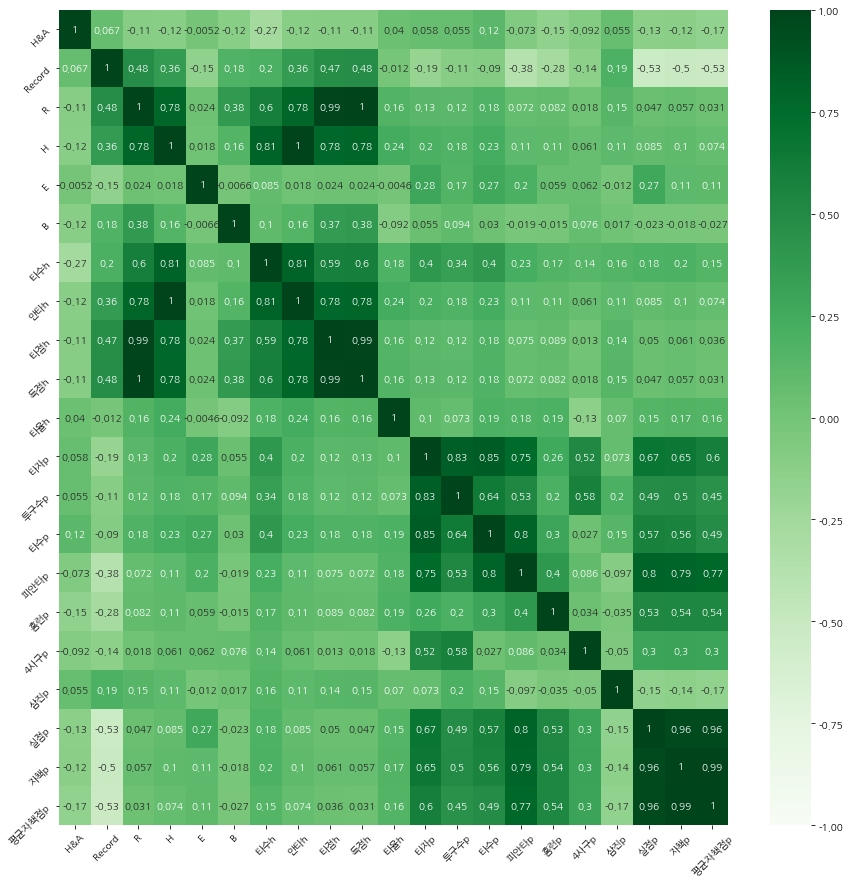

In [ ]:
import seaborn as sb
plt.figure(figsize = (15,15))
plt.rcParams["font.family"] = "NanumGothic"
plt.rc('axes', unicode_minus=False)
sb.heatmap(LG_sample.corr(method='pearson'),
           annot = True, 
           cmap = 'Greens', 
           vmin = -1, vmax=1 , 
          )
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# KNN
### 'R', 'H', 'B', '타수h', '안타h', '타점h', '득점h', '타율h', '삼진p' 선택

In [ ]:
LG_sampletest=LG_sample.loc[:,['R','H','B','타수h','안타h','타점h','득점h','타율h','삼진p']]

X=LG_sampletest.iloc[:,:].to_numpy()
y=LG_sample.iloc[:,1].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(len(X_train), len(X_test))
print(X_train[:3])
print(y_train[:3])

483 208
[[ 2.     9.     1.    31.     9.     1.     2.     0.284  6.   ]
 [ 4.    10.     4.    35.    10.     4.     4.     0.258  4.   ]
 [10.    11.     8.    36.    11.     9.    10.     0.252  6.   ]]
[1 1 1]


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
for col in range(9):
    print(f'평균 = {X_train[:, col].mean()}, 표준편차= {X_train[:, col].std()}')
for col in range(9):
    print(f'평균 = {X_test[:, col].mean()}, 표준편차= {X_test[:, col].std()}')

평균 = 9.37828145024977e-17, 표준편차= 1.0000000000000007
평균 = -5.148860404058697e-17, 표준편차= 1.0000000000000007
평균 = -5.148860404058697e-17, 표준편차= 1.0000000000000004
평균 = 4.413308917764597e-17, 표준편차= 0.9999999999999999
평균 = -5.148860404058697e-17, 표준편차= 1.0000000000000007
평균 = 1.0297720808117394e-16, 표준편차= 0.9999999999999992
평균 = 9.37828145024977e-17, 표준편차= 1.0000000000000007
평균 = -1.0459542135102096e-14, 표준편차= 0.9999999999999997
평균 = -7.447458798727759e-17, 표준편차= 1.0000000000000004
평균 = -0.05445985508120353, 표준편차= 0.9595279483380883
평균 = -0.006013459430316696, 표준편차= 0.9460907283209695
평균 = -0.04869653989150716, 표준편차= 1.0518052742269874
평균 = 0.014565676966296907, 표준편차= 0.993031178469894
평균 = -0.006013459430316696, 표준편차= 0.9460907283209695
평균 = -0.04824349275853593, 표준편차= 0.9660873472648539
평균 = -0.05445985508120353, 표준편차= 0.9595279483380883
평균 = -0.10442195358646798, 표준편차= 1.0856449291045531
평균 = 0.0171931471151232, 표준편차= 0.9718347796434361


In [ ]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

report = classification_report(y_test, y_pred, zero_division=0)
print(report)

print("테스트 세트 정확도: {:.2f}".format(classifier.score(X_test, y_test)))

[0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0
 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0
 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0
 0 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 1
 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0 2 1 1 0 1 1 0]
[[70 22  1]
 [32 77  0]
 [ 4  2  0]]
              precision    recall  f1-score   support

           0       0.66      0.75      0.70        93
           1       0.76      0.71      0.73       109
           2       0.00      0.00      0.00         6

    accuracy                           0.71       208
   macro avg       0.47      0.49      0.48       208
weighted avg       0.69      0.71      0.70       208

테스트 세트 정확도: 0.71
